Descripción de los datos

Cada entrada de registro es una acción de usuario o un evento.

    EventName: nombre del evento.
    DeviceIDHash: identificador de usuario unívoco.
    EventTimestamp: hora del evento.
    ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

Instrucciones para completar el proyecto

Paso 1. Abrir el archivo de datos y leer la información general

Ruta de archivo: */datasets/logs_exp_us.csv* 


In [1]:
# se importan las librerias necesarias para el analisis de datos
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt


def looks(datos):
    """Genera un análisis de todo el set de datos de manera global"""

    print("Se ejecuta la descripción de los datos:")
    print(datos.describe(include="all"))
    print()
    print("se hace exploración con método info:")
    print(datos.info())
    print()
    print("se hace una observación con el método Sample:")
    if len(datos) > 10:
        print(datos.sample(10))
    else:
        print(datos)
    print()
    print("hay NA?:")
    print(datos.isna().sum())
    print()
    print("Duplicados:")
    print(datos.duplicated().sum())

In [2]:
data = pd.read_csv('logs_exp_us.csv' , sep='\t')
looks(data)

Se ejecuta la descripción de los datos:
               EventName  DeviceIDHash  EventTimestamp          ExpId
count             244126  2.441260e+05    2.441260e+05  244126.000000
unique                 5           NaN             NaN            NaN
top     MainScreenAppear           NaN             NaN            NaN
freq              119205           NaN             NaN            NaN
mean                 NaN  4.627568e+18    1.564914e+09     247.022296
std                  NaN  2.642425e+18    1.771343e+05       0.824434
min                  NaN  6.888747e+15    1.564030e+09     246.000000
25%                  NaN  2.372212e+18    1.564757e+09     246.000000
50%                  NaN  4.623192e+18    1.564919e+09     247.000000
75%                  NaN  6.932517e+18    1.565075e+09     248.000000
max                  NaN  9.222603e+18    1.565213e+09     248.000000

se hace exploración con método info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data

In [3]:
#Se exploran los duplicados para ver si hay duplicados reales, Se determina que no, solo son distintos eventos para el mismo dispositivo, o el mismo evento para distintos dispositivos
print(data[data.duplicated()].sort_values('DeviceIDHash').head(15))

                      EventName        DeviceIDHash  EventTimestamp  ExpId
130558         MainScreenAppear   33176906322804559      1564933075    248
130995       OffersScreenAppear   33176906322804559      1564933763    248
104108         CartScreenAppear   34565258828294726      1564857221    248
159302  PaymentScreenSuccessful   54903596035630984      1565011672    248
176813  PaymentScreenSuccessful   77364241990273403      1565044732    246
189896         MainScreenAppear   91292479590032512      1565087723    246
155464         MainScreenAppear   95206628315371849      1565005724    247
110479         MainScreenAppear  170935625628929269      1564897487    246
34223          CartScreenAppear  197027893265565660      1564684544    246
17037          CartScreenAppear  197027893265565660      1564659614    246
112562         CartScreenAppear  197027893265565660      1564902904    246
144045         CartScreenAppear  197027893265565660      1564983860    246
23421          CartScreen


Paso 2. Preparar los datos para el análisis

    Cambia el nombre de las columnas de manera que sea conveniente para ti.
    Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.
    Agrega una columna de fecha y hora y una columna separada para las fechas.

In [4]:
data['daytime'] = data['EventTimestamp'].apply(lambda x: dt.datetime.fromtimestamp(x))
data['date'] = data['daytime'].dt.date
data

,EventName,DeviceIDHash,EventTimestamp,ExpId,daytime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-24 23:43:36,2019-07-24
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 06:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 06:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 06:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 06:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 16:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 16:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 16:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 16:14:58,2019-08-07




Paso 3. Estudiar y comprobar los datos

  -  ¿Cuántos eventos hay en los registros?
  -  ¿Cuántos usuarios hay en los registros?
  -  ¿Cuál es el promedio de eventos por usuario?
  -  ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. Traza un histograma por fecha y hora. ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. ¿Qué periodo representan realmente los datos?
  -  ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?
  -  Asegúrate de tener usuarios de los tres grupos experimentales.


In [5]:
# ¿Cuántos eventos hay en los registros?
print('Nombres de los eventos:')
for event in data['EventName'].unique(): print(event)
print()
print('Número de eventos:',len(data['EventName'].unique()))

Nombres de los eventos:
MainScreenAppear
PaymentScreenSuccessful
CartScreenAppear
OffersScreenAppear
Tutorial

Número de eventos: 5


In [6]:
# ¿Cuántos usuarios hay en los registros?

print('Número de Usuarios:', len(data['DeviceIDHash'].unique()))

Número de Usuarios: 7551


In [7]:
# ¿Cuál es el promedio de eventos por usuario?


print(f"El promedio de eventos por usuario es de: {data.groupby('DeviceIDHash')['EventName'].count().mean():.2f} eventos")

El promedio de eventos por usuario es de: 32.33 eventos


Fecha mínima: 2019-07-24 23:43:36
Fecha máxima: 2019-08-07 16:15:17


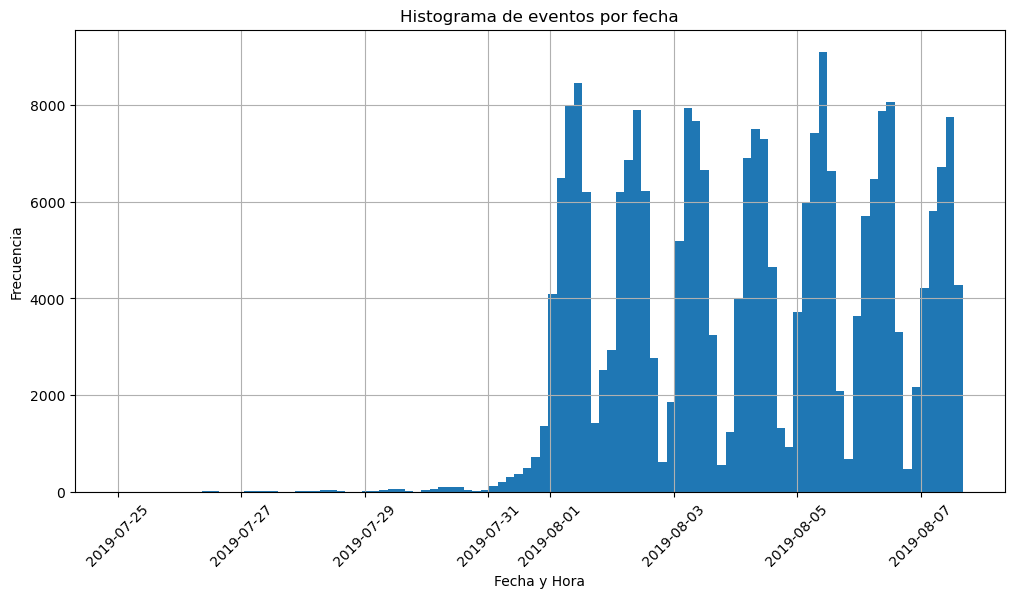

In [8]:
 # ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima. 
print(f"Fecha mínima: {data['daytime'].min()}")
print(f"Fecha máxima: {data['daytime'].max()}")

# Traza un histograma por fecha y hora
plt.figure(figsize=(12, 6))
data['daytime'].hist(bins=100)
plt.xlabel('Fecha y Hora')
plt.ylabel('Frecuencia')
plt.title('Histograma de eventos por fecha')
plt.xticks(rotation=45)
plt.show()

In [9]:
 # ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo? Los eventos más antiguos podrían terminar en los registros de algunos usuarios por razones técnicas y esto podría sesgar el panorama general. 
 # Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior. 
data_f = data[data['date'] > pd.to_datetime('2019-08-01').date()]
 # ¿Qué periodo representan realmente los datos?
print('Se observa que los datos son mas consistentes y parecen estar mas completos apartir del primero de agosto')
print()
print(data_f.head())


Se observa que los datos son mas consistentes y parecen estar mas completos apartir del primero de agosto

                EventName         DeviceIDHash  EventTimestamp  ExpId  \
42842            Tutorial  7002515446915619058      1564722004    248   
42843  OffersScreenAppear   967080911133369983      1564722008    247   
42844    MainScreenAppear  4868351371370467118      1564722015    248   
42845    MainScreenAppear  1188589065896424825      1564722040    246   
42846    MainScreenAppear  3024197421055968640      1564722046    247   

                  daytime        date  
42842 2019-08-02 00:00:04  2019-08-02  
42843 2019-08-02 00:00:08  2019-08-02  
42844 2019-08-02 00:00:15  2019-08-02  
42845 2019-08-02 00:00:40  2019-08-02  
42846 2019-08-02 00:00:46  2019-08-02  


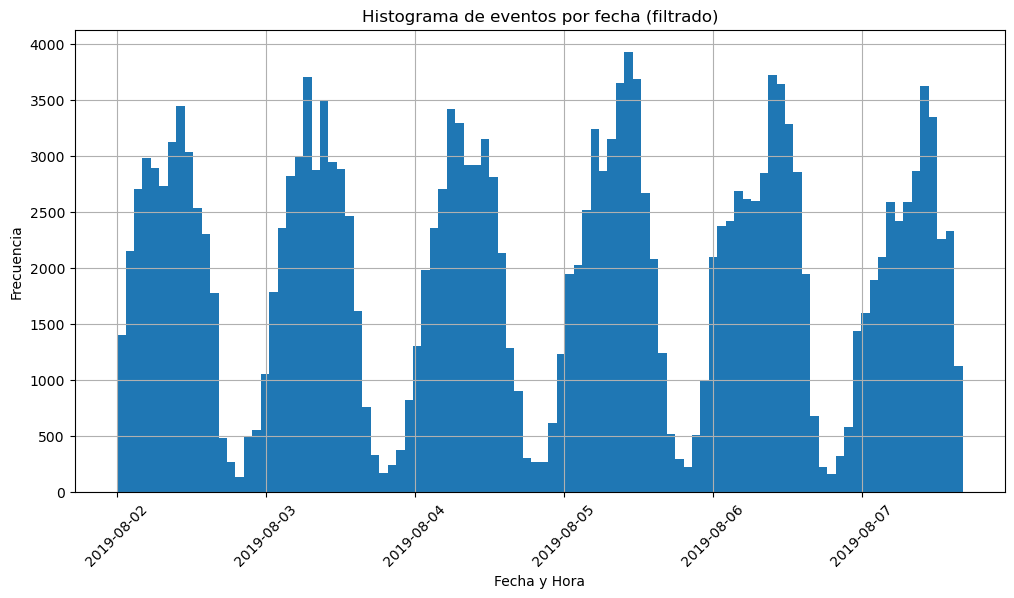

In [10]:
# Traza un histograma por fecha y hora
plt.figure(figsize=(12, 6))
data_f['daytime'].hist(bins=100)
plt.xlabel('Fecha y Hora')
plt.ylabel('Frecuencia')
plt.title('Histograma de eventos por fecha (filtrado)')
plt.xticks(rotation=45)
plt.show()

Se observa que hay una tendencia a utilizar la app en aproximadamente la misma hora del dia


Paso 4. Estudiar el embudo de eventos

    Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
    Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.
    ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
    Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.
    ¿En qué etapa pierdes más usuarios?
    ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?


In [11]:
#  Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.
data_f.groupby('EventName')['daytime'].agg('count').sort_values()

EventName
Tutorial                     774
PaymentScreenSuccessful    28284
CartScreenAppear           35036
OffersScreenAppear         38857
MainScreenAppear           98333
Name: daytime, dtype: int64

Se observa que el evento mas frecuente es ver la pantalla principal, por el contrario casi ningun usuario realizo el tutorial 

In [12]:
#Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios.
eventByUser = data_f.groupby('EventName')['DeviceIDHash'].nunique().sort_values(ascending= False)
# Calcula la proporción de usuarios que realizaron la acción al menos una vez.
n_usuarios = data_f['DeviceIDHash'].nunique()

print('El numero de eventos por usuario es:')
print(eventByUser)
print()
print('la proporcion es:')
print(eventByUser/n_usuarios)


El numero de eventos por usuario es:
EventName
MainScreenAppear           7138
OffersScreenAppear         4366
CartScreenAppear           3561
PaymentScreenSuccessful    3392
Tutorial                    674
Name: DeviceIDHash, dtype: int64

la proporcion es:
EventName
MainScreenAppear           0.981978
OffersScreenAppear         0.600633
CartScreenAppear           0.489889
PaymentScreenSuccessful    0.466639
Tutorial                   0.092723
Name: DeviceIDHash, dtype: float64


Se observa que menos de la mitad de usuarios que abren la aplicacion concretan la compra 

In [13]:
# definimos una funcion para uso posterior 

def funnl_ord(data, funnel):
    """ Se genera una funcion para establecer el orden de eventos. 
    Se toman dos argumentos; el origen de los datos y el funnel ordenado de los eventos"""

    funn_eve = pd.DataFrame(columns=['event', 'unique_users', 'proportion'])

    for i in range(len(funnel) - 1):
        current_event = funnel[i]
        next_event = funnel[i + 1]

        current_users = data[data['EventName'] == current_event]['DeviceIDHash'].unique()
        next_users = data[data['EventName'] == next_event]['DeviceIDHash'].unique()

        proportion = len(set(next_users) & set(current_users)) / len(current_users)

        new_row = pd.DataFrame({'event': [next_event], 'unique_users': [len(next_users)], 'proportion': [proportion]})
        funn_eve = pd.concat([funn_eve, new_row], ignore_index=True)
    print(funn_eve)

In [14]:
#¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
#Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.
#¿En qué etapa pierdes más usuarios?

#Debido a que los usuarios parecen omitir el tutorial no se considera para el embudo de eventos 
#se genera embudo
funnel = ['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

funnl_ord(data_f,funnel)


                     event unique_users  proportion
0       OffersScreenAppear         4366    0.593864
1         CartScreenAppear         3561    0.804627
2  PaymentScreenSuccessful         3392    0.951137


/tmp/ipykernel_3251/1018595354.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  funn_eve = pd.concat([funn_eve, new_row], ignore_index=True)


Se observa que poco mas de la mitad de usuarios que abren la apliacion pasan a la pantalla de oferta pero el 80% de esos agregan el prducto a su carrito y casi el 100% de los usuarios con producto en el carrito realizan la compra 

In [15]:
#  ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?
def user_full_trip(data, funnel, show=True):
    """ Se genera una funcion para dar el porcentaje de usuarios que recorren el funnel completo
    desde el inicio hasta el final"""

    # Encuentra los usuarios que realizaron el primer evento
    first_event_users = data[data['EventName'] == funnel[0]]['DeviceIDHash'].unique()
    # Encuentra los usuarios que realizaron el último evento (pago)
    last_event_users = data[data['EventName'] == funnel[-1]]['DeviceIDHash'].unique()
    # Calcula el porcentaje de usuarios que realizaron todo el viaje
    percentage_full_journey = len(set(last_event_users) & set(first_event_users)) / len(first_event_users) * 100
    
    if show:
        print(f"El porcentaje de usuarios que hace todo el viaje desde su primer evento hasta el pago es: {percentage_full_journey:.2f}%")
    else:
        return percentage_full_journey


user_full_trip(data_f,funnel)

El porcentaje de usuarios que hace todo el viaje desde su primer evento hasta el pago es: 46.01%



Paso 5. Estudiar los resultados del experimento

   - ¿Cuántos usuarios hay en cada grupo?
   - Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
   - Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?
   - Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
   - ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [26]:
# Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247

# Crear una tabla de contingencia
contingency_table = pd.crosstab(
    data_f[data_f['ExpId'] != 248]['EventName'], data_f[data_f['ExpId'] != 248]['ExpId'])

# Realizar la prueba chi-cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(contingency_table)
print(f"P-value: {p:4f}")

# Verificar si el resultado es estadísticamente significativo
alpha = 0.05
if p < alpha:
    print("Hay una diferencia estadísticamente significativa entre las muestras 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre las muestras 246 y 247.")

ExpId                      246    247
EventName                            
CartScreenAppear         12345  10295
MainScreenAppear         31901  32511
OffersScreenAppear       12562  12643
PaymentScreenSuccessful  10074   8312
Tutorial                   258    251
P-value: 0.000000
Hay una diferencia estadísticamente significativa entre las muestras 246 y 247.


Se observa que las propociones de usuarios entre eventos entre los eventos control son diferentes, por lo que se considera que debe existir un error de separacion de la muestra. Es decir estan separados de manera incorrecta para formar dos grupos 

In [17]:
#ver evento mas popular
data_f.pivot_table(index='EventName', columns='ExpId', aggfunc='nunique', values='DeviceIDHash')

ExpId,246,247,248
EventName,,,
CartScreenAppear,1208,1182,1171
MainScreenAppear,2351,2382,2405
OffersScreenAppear,1475,1434,1457
PaymentScreenSuccessful,1149,1116,1127
Tutorial,222,220,232


Se encuentra que el evento mas popular es la presenciation de la pantalla principal